##**Modelo de Detección**

---



###Librerías

In [ ]:
# Instalar ultralytics para YOLO
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# Importar librerías
from ultralytics import YOLO
import torch
from google.colab import drive
import os
import time
import cv2
import numpy as np
import yaml
import colorsys
import torch.backends.cudnn as cudnn
from PIL import Image
from collections import defaultdict
import albumentations as A
import random
import shutil
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


###Acceso a Gooogle Drive

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


###Seleccionamos el modelo YOLO.

In [ ]:
# Configurar los parámetros del modelo YOLOV11X
model = YOLO('yolo11x.pt')

100%|██████████| 109M/109M [00:00<00:00, 166MB/s]


###Aumento de las imágenes para el entrenamiento

In [ ]:
# Rutas de carpetas en Google Drive
train_folder = "/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/hen_detection_dataset/train/images"
label_folder = "/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/hen_detection_dataset/train/labels"
os.makedirs(train_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)

# Obtener lista de imágenes en train
image_files = [f for f in os.listdir(train_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(image_files)  # Mezclar imágenes para selección aleatoria

In [ ]:
# Número total de imágenes en train
total_images = len(image_files)
images_per_augmentation = round(total_images / 4)  # Distribuir imágenes equitativamente entre 4 técnicas

# Dividir imágenes en grupos dinámicos según la cantidad en train
noise_images = image_files[:images_per_augmentation]
gray_images = image_files[images_per_augmentation:images_per_augmentation*2]
brightness_images = image_files[images_per_augmentation*2:images_per_augmentation*3]
saturation_images = image_files[images_per_augmentation*3:]

In [ ]:
# Definir transformaciones
transforms = {
    "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    "gray": A.ToGray(p=1.0),
    "brightness": A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
    "saturation": A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=1.0)
}

<ipython-input-8-c5655a09d551>:3: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  "noise": A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


In [ ]:
# Aplicar transformaciones y guardar imágenes con etiquetas
def apply_augmentation(image_list, transform, prefix):
    for img_file in image_list:
        img_path = os.path.join(train_folder, img_file)
        label_path = os.path.join(label_folder, os.path.splitext(img_file)[0] + ".txt")

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)['image']
        output_img_path = os.path.join(train_folder, f"{prefix}_{img_file}")
        Image.fromarray(augmented).save(output_img_path)

        # Copiar etiqueta si existe
        if os.path.exists(label_path):
            output_label_path = os.path.join(label_folder, f"{prefix}_{img_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')}")
            shutil.copy(label_path, output_label_path)

apply_augmentation(noise_images, transforms["noise"], "noise")
apply_augmentation(gray_images, transforms["gray"], "gray")
apply_augmentation(brightness_images, transforms["brightness"], "brightness")
apply_augmentation(saturation_images, transforms["saturation"], "saturation")

print(f"Aumento de imágenes completado. Total de imágenes generadas: {len(os.listdir(train_folder)) - total_images}")

Aumento de imágenes completado. Total de imágenes generadas: 3


###Entrenamiento del modelo de detección

In [ ]:
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/data.yaml',   # Archivo de configuración de los datos
    epochs=100,                             # Número de épocas de entrenamiento
    batch=32,                               # Tamaño del batch (ajusta si ves que consume demasiada RAM)
    imgsz=640,                             # Tamaño de la imagen (640x640 en este caso)
    cache=True                             # Cachear las imágenes para reducir la carga de lectura
)

###Realizamos las predicciones a partir del modelo 'best.pt'

In [ ]:
# Cargar el modelo entrenado (después del entrenamiento)
model = YOLO('/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/runs_model_x/weights/best.pt')

# Directorio de las imágenes de prueba
test_images_path = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images'

# Realizar predicciones en las imágenes de prueba
results = model.predict(
    source=test_images_path,       # Ruta a la carpeta de imágenes de prueba
    conf=0.5,                      # Umbral de confianza para detecciones
    save=True,                     # Guardar las imágenes con los resultados
    save_txt=True,                 # Guardar las etiquetas predichas en formato .txt
    project='/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test',  # Carpeta donde se guardarán los resultados
    name='predictions'             # Subcarpeta donde se almacenarán los resultados
)


image 1/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_194513_jpg.rf.6780b252f76abb6f1015b873817819eb.jpg: 640x480 137 0s, 83.0ms
image 2/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_194525_jpg.rf.247471004ff98a8bae560a8736a92972.jpg: 640x480 135 0s, 70.0ms
image 3/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_194535_jpg.rf.671a07829f41f357514fc52e228cf4ee.jpg: 640x480 136 0s, 70.0ms
image 4/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_194538_jpg.rf.7c69fcc2ca882a9f7d8c2c0d8f8ef29e.jpg: 640x480 136 0s, 70.0ms
image 5/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_194546_jpg.rf.68ecb4b9c0f24288ab44c354e82f89c9.jpg: 640x480 137 0s, 70.0ms
image 6/44 /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/test/images/20240510_

###Realizamos el conteo de las gallinas en cada imagen que predijo el modelo

In [ ]:
# Contar gallinas por imagen
image_hen_counts = {}
for result in results:
    image_name = result.path.split("/")[-1]  # Obtener el nombre de la imagen
    detections = result.boxes  # Obtener las detecciones
    count = len(detections)  # Contar las detecciones en esta imagen
    image_hen_counts[image_name] = count  # Guardar el conteo

# Mostrar resultados
for image, count in image_hen_counts.items():
    print(f"{image}: {count} gallinas detectadas")

20240510_194513_jpg.rf.6780b252f76abb6f1015b873817819eb.jpg: 137 gallinas detectadas
20240510_194525_jpg.rf.247471004ff98a8bae560a8736a92972.jpg: 135 gallinas detectadas
20240510_194535_jpg.rf.671a07829f41f357514fc52e228cf4ee.jpg: 136 gallinas detectadas
20240510_194538_jpg.rf.7c69fcc2ca882a9f7d8c2c0d8f8ef29e.jpg: 136 gallinas detectadas
20240510_194546_jpg.rf.68ecb4b9c0f24288ab44c354e82f89c9.jpg: 137 gallinas detectadas
20240510_194555_jpg.rf.97311c869f3eb4868d6ff39c1b1613a7.jpg: 136 gallinas detectadas
20240510_194622_jpg.rf.9274e683c3b953306ef62b0dcc673513.jpg: 136 gallinas detectadas
20240510_194625_jpg.rf.d41db6180fcacc0893dd84c29746f037.jpg: 134 gallinas detectadas
20240510_194633_jpg.rf.d91ef3f26379e6386ba302973aedabdf.jpg: 133 gallinas detectadas
20240510_194636_jpg.rf.234cef9b3df399e86ede2f8a711493b5.jpg: 130 gallinas detectadas
20240510_194639_jpg.rf.356a93759f3d46cc103925e6193df42d.jpg: 135 gallinas detectadas
20240810_115915_jpg.rf.4b39a4074c9544fb8fcbf1a811416aa6.jpg: 140 

###Ruta de nuestro Modelo de detección

In [ ]:
# Configurar el modelo YOLOv11 con tu modelo entrenado
model_path = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/yolov8_detection/runs_model_x/weights/best.pt'  # Ruta de mi modelo
model = YOLO(model_path)

##**Detección de gallinas en vídeo con nuestro modelo best.pt**

In [ ]:
results=model("/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_Corto2_50_Gallinas.mp4",classes=0,save=True)

##**Tracking mediante BotSORT y Bytetrack**

---

In [ ]:
# Definir la fuente del video
input_video = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4'
output_path_bytetrack = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Result_Vid_50_Gallinas_ByteTrack.mp4'
output_path_botsort = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Result_Vid_110_BotSORT.mp4'
trayectoria = '/content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Result_Vid_110T_BotSORT.mp4'

In [ ]:
# Parámetros para mejorar la detección
CONFIDENCE_THRESHOLD = 0.7  # Umbral de confianza para reducir falsos positivos
MIN_TRACK_LENGTH = 5  # Mínima cantidad de posiciones para considerar un track válido
MIN_AREA = 500  # Mínimo tamaño de un objeto detectado en píxeles

# Escala de conversión px → cm (basado en el ancho de una gallina ≈ 30 cm)
ANCHO_GALLINA_CM = 30
ANCHO_GALLINA_PX = 100  # Estima este valor de acuerdo a tus videos
PX_TO_CM = ANCHO_GALLINA_CM / ANCHO_GALLINA_PX  # Conversión de píxeles a centímetros

In [ ]:
# Variables para estadísticas
tracked_positions = {}
frame_count = 0
cantidad_vs_tiempo = []
velocidad_vs_tiempo = []
distancia_vs_tiempo = []

###Función encargada de dibujar los bounding box y realizar el seguimiento.

In [ ]:
def process_tracking(tracker_type, output_path, max_frames=10000):
    global tracked_positions, frame_count, cantidad_vs_tiempo, velocidad_vs_tiempo, distancia_vs_tiempo

    cantidad_vs_tiempo = []
    results = model.track(source=input_video, persist=True, classes=0, tracker=tracker_type, conf=CONFIDENCE_THRESHOLD, stream=True)

    cap = cv2.VideoCapture(input_video)
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    sidebar_width = 200
    new_width = width + sidebar_width

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, height))

    frame_count = 0
    tracked_positions = {}  # Almacenar todas las trayectorias detectadas

    for result in results:
        if result is None or frame_count >= max_frames or result.orig_img is None:
            break

        frame = result.orig_img.copy()
        current_ids = set()

        # --- TRACKING ---
        if result.boxes is not None:
            ids = result.boxes.id.int().cpu().tolist() if result.boxes.id is not None else []
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()

            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                track_id = ids[i] if i < len(ids) else -1
                confidence = confs[i] if i < len(confs) else 0

                if track_id != -1 and confidence > CONFIDENCE_THRESHOLD:
                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                    current_ids.add(track_id)

                    # Guardar trayectoria
                    if track_id not in tracked_positions:
                        tracked_positions[track_id] = []
                    tracked_positions[track_id].append((center_x, center_y))

                    # Dibujar bounding box e ID en la imagen
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # --- INTERFAZ VISUAL ---
        sidebar = np.zeros((height, sidebar_width, 3), dtype=np.uint8)
        cv2.putText(sidebar, f'Frame: {frame_count}', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(sidebar, f'Gallinas: {len(current_ids)}', (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        combined_frame = np.hstack((frame, sidebar))
        out.write(combined_frame)

        cantidad_vs_tiempo.append(len(current_ids))
        frame_count += 1

    cap.release()
    out.release()

    # 🔹 Mostrar los IDs detectados al final del tracking
    print("✅ Tracking completado. Gallinas detectadas con los siguientes IDs:")
    print(list(tracked_positions.keys()))
    print("🔹 Ingresa el ID de la gallina que quieres seguir en la función draw_trajectory().")

###Función encargada de dibujar la trayectoria de la gallina preseleccionada.

In [ ]:
def draw_trajectory(selected_chicken_id, input_video_path, output_video_path):
    global distancia_vs_tiempo, velocidad_vs_tiempo

    if selected_chicken_id not in tracked_positions:
        print(f"❌ No hay datos para la gallina con ID {selected_chicken_id}")
        return

    cap = cv2.VideoCapture(input_video_path)
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    posiciones = np.array(tracked_positions[selected_chicken_id])
    if len(posiciones) < 2:
        print(f"⚠️ No hay suficientes datos para calcular distancia y velocidad de la gallina con ID {selected_chicken_id}")
        return

    distancia_vs_tiempo = []
    velocidad_vs_tiempo = []

    # Cálculo de distancia y velocidad
    difs = np.diff(posiciones, axis=0)
    distancia_px = np.linalg.norm(difs, axis=1).cumsum()
    distancia_cm = distancia_px * PX_TO_CM
    velocidad_cm_s = np.gradient(distancia_cm) * fps  # Aproximación de velocidad

    # Posición fija en la esquina superior izquierda (4 cm hacia abajo)
    text_x = 20  # Separado del borde izquierdo
    text_y = int(4 / PX_TO_CM) + 20  # Convertir 4 cm a píxeles y ajustar

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count >= len(posiciones):
            break

        # Dibujar trayectoria acumulada hasta el frame actual
        for j in range(1, frame_count + 1):
            if j < len(posiciones):
                cv2.line(frame, tuple(posiciones[j - 1]), tuple(posiciones[j]), (255, 0, 0), 4)

        # 📌 Agregar distancia y velocidad en la esquina superior izquierda
        if frame_count < len(distancia_cm):
            cv2.putText(frame, f'Dist: {distancia_cm[frame_count]:.2f} cm', (1100, text_y + 118),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, f'Vel: {velocidad_cm_s[frame_count]:.2f} cm/s', (1100, text_y + 170),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            distancia_vs_tiempo.append(distancia_cm[frame_count])
            velocidad_vs_tiempo.append(velocidad_cm_s[frame_count])

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
    print("✅ Video con trayectoria, distancia y velocidad generado correctamente.")

###Función encargada de realizar los gráficos de Cantidad, Distancia y Velocidad vs Tiempo (Frames)

In [ ]:
def plot_metrics():
    global cantidad_vs_tiempo, distancia_vs_tiempo, velocidad_vs_tiempo

    tiempo_frames_cantidad = np.arange(len(cantidad_vs_tiempo))
    tiempo_frames_tracking = np.arange(len(distancia_vs_tiempo))

    plt.figure(figsize=(10, 6))

    # 🔹 Cantidad de gallinas vs tiempo
    plt.subplot(3, 1, 1)
    plt.plot(tiempo_frames_cantidad, cantidad_vs_tiempo, label='Cantidad de gallinas', color='b')
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Cantidad')
    plt.legend()

    # 🔹 Velocidad vs tiempo
    plt.subplot(3, 1, 2)
    plt.plot(tiempo_frames_tracking, velocidad_vs_tiempo, label='Velocidad (cm/s)', color='r')
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Velocidad (cm/s)')
    plt.legend()

    # 🔹 Distancia vs tiempo
    plt.subplot(3, 1, 3)
    plt.plot(tiempo_frames_tracking, distancia_vs_tiempo, label='Distancia recorrida (cm)', color='g')
    plt.xlabel('Tiempo (frames)')
    plt.ylabel('Distancia (cm)')
    plt.legend()

    plt.tight_layout()
    plt.show()

####Ejecuta el tracking mediante ByteTrack

In [ ]:
process_tracking('bytetrack.yaml', output_path_bytetrack)

####Ejecuta el tracking mediante BotSORT

In [ ]:
process_tracking('botsort.yaml', output_path_botsort)


video 1/1 (frame 1/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 62.5ms
video 1/1 (frame 2/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 62.5ms
video 1/1 (frame 3/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 62.5ms
video 1/1 (frame 4/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 62.5ms
video 1/1 (frame 5/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 62.5ms
video 1/1 (frame 6/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sort/videos/Vid_110_Gallinas.mp4: 640x384 1 0, 59.1ms
video 1/1 (frame 7/10811) /content/drive/MyDrive/Colab Notebooks/yolov8_tracking/Deep_SORT/deep_sor

###Se escoge la gallina a la cual se le medirá y dibujará la trayectoria.

In [ ]:
draw_trajectory(306, output_path_botsort, trayectoria)

###Grafica los resultados obtenidos

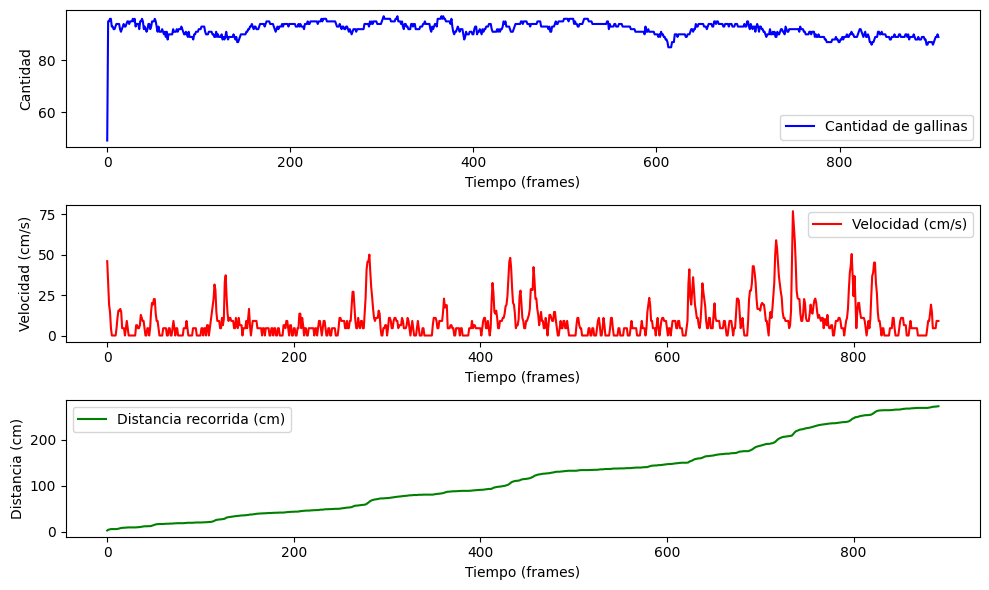

In [ ]:
# Graficar métricas
plot_metrics()